# UCLA Results Validation

This notebook is aimed at attemping to validate the results achieved by UCLA in their paper

In [1]:
from protestDB import cursor
import time
from protestDB import models
from lib import analysis_utils as au
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import scipy
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
import h5py

from lib import transforms

/home/jesper/Documents/itu/2_year/thesis/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading up the data

In [2]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


40720

Get the labels

In [3]:

cols = ["name", "label", "protest"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
split_tags = ['ucla-test', 'ucla-train']
imgs = imgs[cols + tag_cols + split_tags]
indx_non_violence = imgs['label'].isnull()

imgs.loc[:,tag_cols] = imgs.loc[:,tag_cols].astype(int)
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
94c4c6443cbc9c14,test-00002.jpg,0.122890,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
83a2860706c6e5e4,test-00004.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
1890151c5859c8f8,test-00005.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
7f5b59cbdc543c2c,test-00006.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
6264e0c0a0c0a0d0,test-00007.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
eee6e6e6c68f95b5,test-00008.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False


### Pre-processing

In [4]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1
# df.loc[indx_non_violence, 'violence'] = -1

# masks the visual attributes that where image is not a protest
# for column, value in df.iloc[:,3:].iteritems(): # fill visual attributes with masking
#     df.loc[pd.isnull(df['protest']), column] = -1
imgs.loc[indx_non_violence, tag_cols] = -1
    
# fill nas
# df.fillna(0, inplace = True)

# df = imgs.rename(columns={"label": "violence"})
df = imgs
df

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
94c4c6443cbc9c14,test-00002.jpg,0.285790,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
83a2860706c6e5e4,test-00004.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
1890151c5859c8f8,test-00005.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
7f5b59cbdc543c2c,test-00006.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
eee6e6e6c68f95b5,test-00008.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False


In [5]:
i = df['violence'].idxmax()
df.loc[i]

name          test-03961.jpg
violence                   1
protest                 True
sign                       1
photo                      0
fire                       1
police                     0
children                   0
group_20                   1
group_100                  0
flag                       0
night                      0
shouting                   0
ucla-test               True
ucla-train             False
Name: a3a5e2a0d0d8a52c, dtype: object

Get the images

In [6]:
batch_size = 32

# df = df.rename(columns={"label": "violence"})

train_idx = df['ucla-train']
train = df.loc[train_idx, ["name", "violence", "protest"] + tag_cols]

test_idx = df['ucla-test']
test = df.loc[test_idx, ["name", "violence", "protest"] + tag_cols]

# ...and as UCLA used their test set also for validation:
val = test

# size in percentage of the various splits:
# test_size = .2
# val_size = .2
# train_size = .6

# train, val, test = au.getSplits(df, train_size, val_size, test_size)
print("{} rows split into train: {}, validation: {}, and test: {}".format(len(df), len(train), len(val), len(test)))
train

40720 rows split into train: 32568, validation: 8152, and test: 8152


,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
8ee833bb38bccd14,train-00000.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
0dcccaecd4d4fe13,train-00001.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
343372a3a3a5010a,train-00002.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
42434b6f73f3a3ba,train-00004.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
c6d8fad352526460,train-00005.jpg,0.345004,True,1,0,0,0,0,0,0,0,0,0
9a134b117159595d,train-00006.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2c85ccc4c4e4d4f0,train-00007.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
53696d65584a5959,train-00008.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
c79311899979cf8a,train-00009.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [63]:
dummy_test_generator = au.ResizeSequence(
    df[np.random.randint(100):np.random.randint(100, 200)],
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalize # looks pretty weird after this
    ] 
)
train_generator = au.ResizeSequence(
    train,
    batch_size, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.randomResizedCrop,
        transforms.randomRotation,
        transforms.randomHorizontalFlip,
        transforms.colorJitter,
        transforms.normalize
    ]
)
validation_generator = au.ResizeSequence(val, batch_size, 
                                         targets = ['protest', 'violence', tag_cols])
test_generator = au.ResizeSequence(test, 1, 
                                   targets = ['protest', 'violence', tag_cols])

test_visual = test[tag_cols]
test_violence = test['violence'] 
test_protest = test['protest']

protest has shape (32,)  violence has shape (32,)  visual has shape (32, 10)


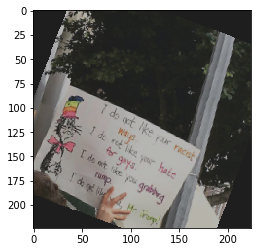

In [76]:
first = next(dummy_test_generator.__iter__())
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
visual = first[1][2]
img = np.array(image)
plt.imshow(img)
print("protest has shape", protest.shape, " violence has shape", violence.shape, " visual has shape", visual.shape)

Select training and validation sets

### Modeling

In [9]:
mask_value = -1
Kbackend.clear_session()

In [10]:
img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(flatten)
visual_out = Klayers.Dense(10, activation='sigmoid', name='visual_out')(flatten)

model = Kmodels.Model(inputs= img_input, outputs=[protest_out, violence_out, visual_out])




In [11]:
lr = 0.01; momentum = 0.9; epochs = 1000; patience = 15

In [12]:
optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(optimizer=optimizer,
              loss={'protest_out': Klosses.binary_crossentropy,
                    'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
                    'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 5, 
                            'violence_out': 10 })
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
protest_out (Dense)             (None, 1)            2049        flatten_1[0][0]                  
__________________________________________________________________________________________________
violence_o

In [13]:
try:
    __file__ # Apparently, this is not defined in the notebook,
             # but it will be when we start running on the server
             # (So when things gets real)
except NameError:
    __file__ = "test"
    
name = au.getExperimentName(__file__, len(df), epochs, lr, "test")
model_checkout_path = "models/%s.hdf5" % name
csv_logger_path = "logs/%s.csv" % name

print("Writing model to: \t%s" % model_checkout_path)
print("Writing log to: \t%s\n" % csv_logger_path)

# callbacks
change_lr = Kcallbacks.LearningRateScheduler(au.lrUpdateUCLA, 
                                            verbose = True)

checkpoint = Kcallbacks.ModelCheckpoint(model_checkout_path,
                                       monitor='val_loss', 
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto',
                                       period=1)

# Disable for now:
# earlystop = Kcallbacks.EarlyStopping(monitor='val_loss',
#                                     min_delta=0, 
#                                     patience=patience,
#                                     verbose=1, 
#                                     mode='auto')

tensor_board = Kcallbacks.TensorBoard(log_dir='logs/',
                                     histogram_freq=0,
                                     batch_size=32, 
                                     write_graph=True,
                                     write_grads=False, 
                                     write_images=False, 
                                     embeddings_freq=0,
                                     embeddings_layer_names=None,
                                     embeddings_metadata=None)

csv_logger = Kcallbacks.CSVLogger(csv_logger_path, 
                                 separator=',', 
                                 append=False)

Writing model to: 	models/test_datalen-40720_epochs-1000_init_lr-0.01_test.hdf5
Writing log to: 	logs/test_datalen-40720_epochs-1000_init_lr-0.01_test.csv



In [15]:
history = model.fit_generator(
    train_generator,
    validation_data= validation_generator,
    epochs=epochs,
    callbacks = [change_lr, checkpoint, tensor_board, csv_logger])

Epoch 1/1000


/home/jesper/Documents/itu/2_year/thesis/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.


KeyboardInterrupt: 

### Test set evaluation

In [ ]:
preds = model.predict_generator(test_generator)
preds_protest = preds[0]
preds_violence = preds[1]
preds_visual = preds[2]
print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape, "visual shape is ", preds_visual.shape)

### Protest

In [ ]:
au.plotROC("protest", test_protest, preds_protest, save_as="logs/ROC_protest.png")

### Visual

In [ ]:
for i in range(preds_visual.shape[1]):
    pred = preds_visual[:,i]
    target = test_visual.iloc[:,i]
    
    # remove masked values from test set
    target_non_masked = target[target!= -1]
    pred_non_masked = pred[target!= -1]
    
    attr_indx = 3 + i # the visual attributes start from the 4th pos
    attr = df.columns[attr_indx]
    print(attr)
    try:
        au.plotROC(attr, target_non_masked, pred_non_masked, save_as="logs//ROC_{}.png".format(i))
    except Exception as e:
        print(e)

### Violence

In [ ]:
# remove masked values from test set
non_masked_violence_true = test_violence[test_violence!= -1].tolist()
non_masked_violence_preds = preds_violence[test_violence!= -1].flatten().tolist()

In [ ]:
fig, ax = plt.subplots()
plt.scatter(non_masked_violence_true, non_masked_violence_preds, label = "violence")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = scipy.stats.pearsonr(non_masked_violence_true, non_masked_violence_preds)
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f})'
            .format(attr = "violence", corr= corr)), fontsize = 15)
plt.savefig("logs/pred_vs_truth_scatter.png")